Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [53]:
import io
import os

In [50]:
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
import numpy as np
import tensorflow as tf

2025-07-22 22:05:29.859816: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 22:05:29.867813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753243529.877403 1722946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753243529.880166 1722946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753243529.887275 1722946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
from tensorflow_dynamics.de import OdeintSolver

W0000 00:00:1753243530.827593 1722946 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
import tensorflow_dynamics as tfd

In [6]:
tf.keras.backend.set_floatx('float64')

In [7]:
x = np.linspace(1, 10, 1000)

In [8]:
y = np.cos(2 * np.pi * x) / x**2

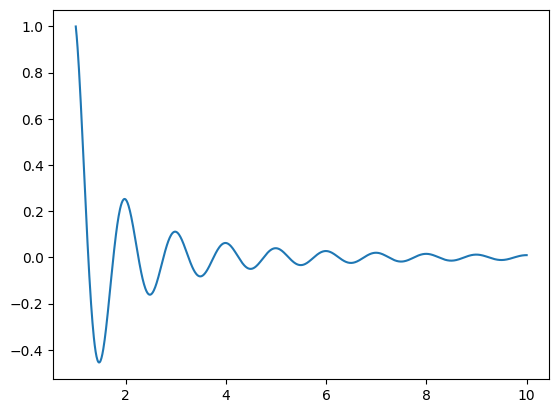

In [9]:
plt.plot(x, y)
plt.show()

In [10]:
def y(x: np.ndarray) -> np.ndarray:
    return np.cos(2 * np.pi * x) / x**2

In [11]:
def dy_dx(x: np.ndarray) -> np.ndarray:
    return -(2 / x**3)*np.cos(2 * np.pi * x) - (2 * np.pi * np.sin(2 * np.pi * x)) / x**2

In [12]:
y_x = y(x)
dy_x_dx = dy_dx(x)

In [13]:
y_x.shape

(1000,)

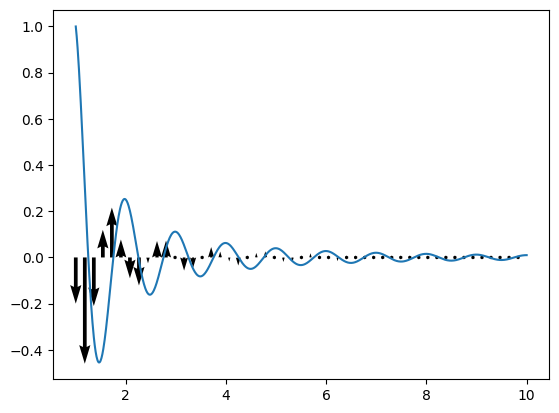

In [14]:
y_quiver = np.zeros_like(x)
plt.plot(x, y_x)
dx_step = 20
plt.quiver(x[::dx_step],
           y_quiver[::dx_step],
           y_quiver[::dx_step],
           dy_x_dx[::dx_step],
           angles='xy', scale=10, scale_units='y', units='y')
plt.show()

In [15]:
x_tf = tf.cast(tf.constant(x), tf.float64)
y_x_tf = tf.cast(tf.constant(y_x), tf.float64)
y_x_t_0_tf = y_x_tf[None, :1]
y_x_t_f_tf = y_x_tf[-1:]

In [16]:
y_x_tf_batch = tf.stack(tf.split(y_x_tf, 100))
x_tf_batch = tf.stack(tf.split(x_tf, 100))

In [17]:
print(y_x_tf_batch.shape)
print(x_tf_batch.shape)

(100, 10)
(100, 10)


In [18]:
print(y_x_tf_batch[0, :])
print(x_tf_batch[0, :])

tf.Tensor(
[1.         0.9806494  0.95873815 0.93442395 0.90786538 0.87922155
 0.84865169 0.81631482 0.78236933 0.7469727 ], shape=(10,), dtype=float64)
tf.Tensor(
[1.         1.00900901 1.01801802 1.02702703 1.03603604 1.04504505
 1.05405405 1.06306306 1.07207207 1.08108108], shape=(10,), dtype=float64)


In [19]:
class TimeDerivativeMLP(tf.keras.Model):
    def __init__(self):
        super().__init__()

        dense_layers = []
        for nodes in [32, 32, 32]:
            mid_layer = tf.keras.layers.Dense(nodes, 'tanh', dtype=tf.float64)
            dense_layers.append(mid_layer)
        
        self._dense_layers = dense_layers
        self._out_layer = tf.keras.layers.Dense(1, None, dtype=tf.float64)

    def call(self, t: tf.Tensor, x: tf.Tensor) -> tf.Tensor:
        t = t[..., None]
        for dense_layer in self._dense_layers:
            t = dense_layer(t)
        return self._out_layer(t)

In [20]:
x_tf_batch.shape

TensorShape([100, 10])

In [43]:
x_tf.shape

TensorShape([1000])

  0%|          | 0/5000 [00:00<?, ?it/s]

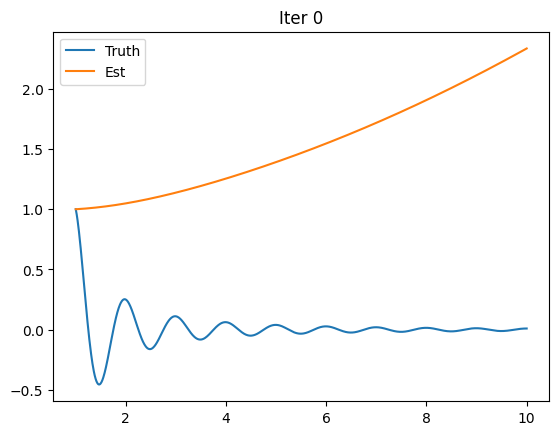

  2%|▏         | 100/5000 [01:05<30:39,  2.66it/s] 

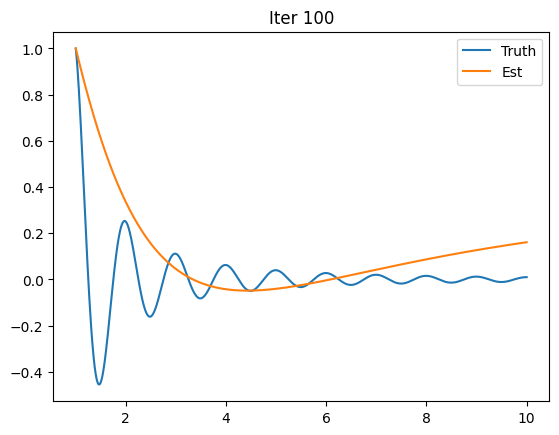

  4%|▍         | 200/5000 [01:41<30:12,  2.65it/s]  

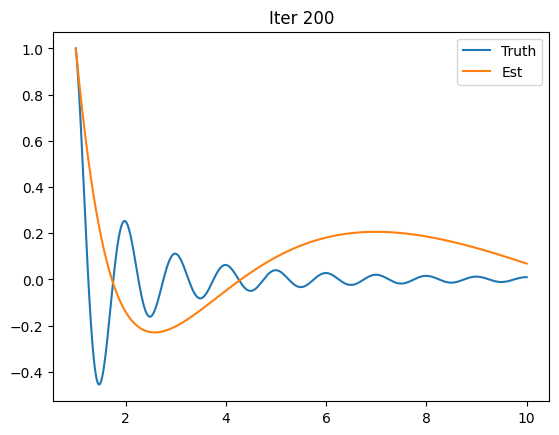

  6%|▌         | 300/5000 [02:18<20:12,  3.88it/s]  

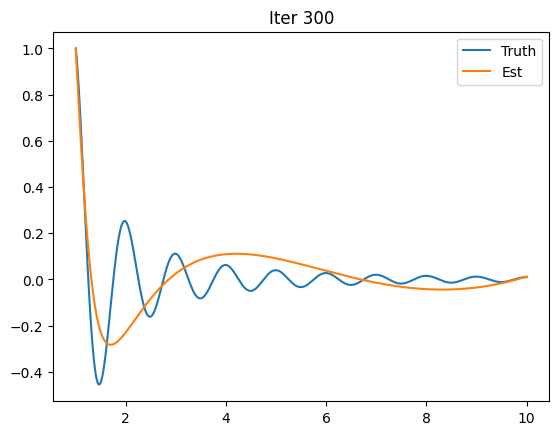

  8%|▊         | 400/5000 [02:52<19:36,  3.91it/s]  

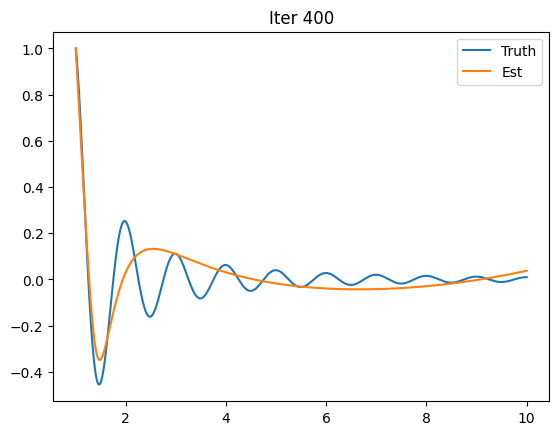

 10%|█         | 500/5000 [03:25<19:20,  3.88it/s]  

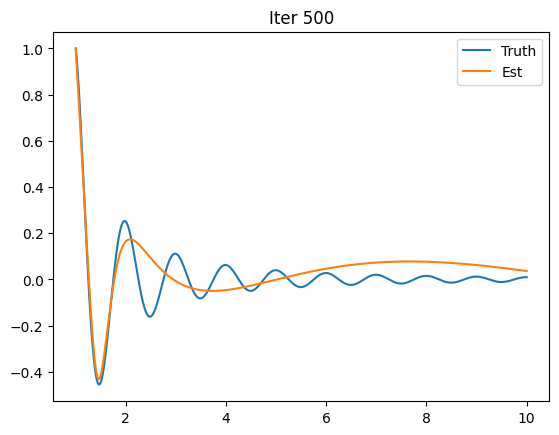

 12%|█▏        | 600/5000 [03:58<18:39,  3.93it/s]  

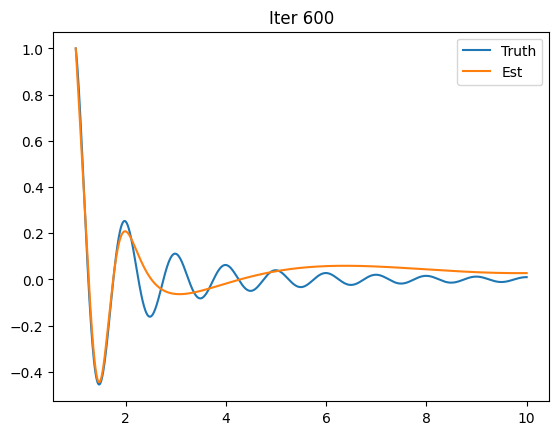

 14%|█▍        | 700/5000 [04:32<18:14,  3.93it/s]  

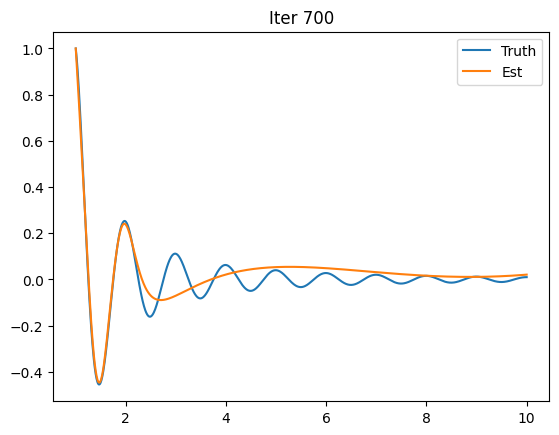

 16%|█▌        | 800/5000 [05:05<17:57,  3.90it/s]  

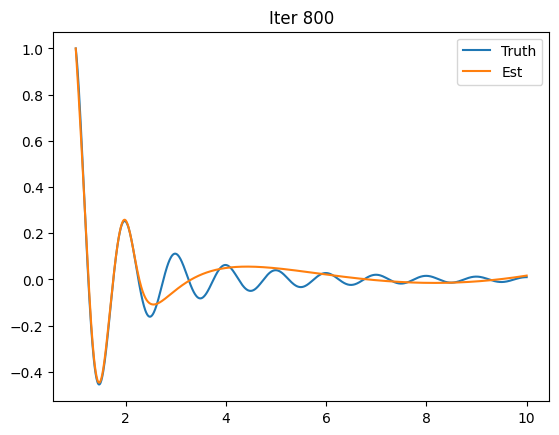

 18%|█▊        | 900/5000 [05:38<17:27,  3.91it/s]  

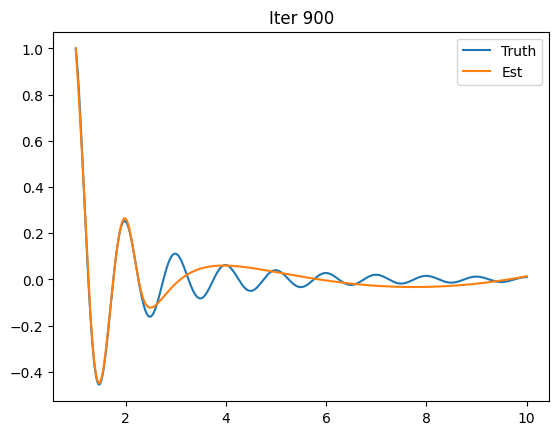

 20%|██        | 1000/5000 [06:12<17:07,  3.89it/s] 

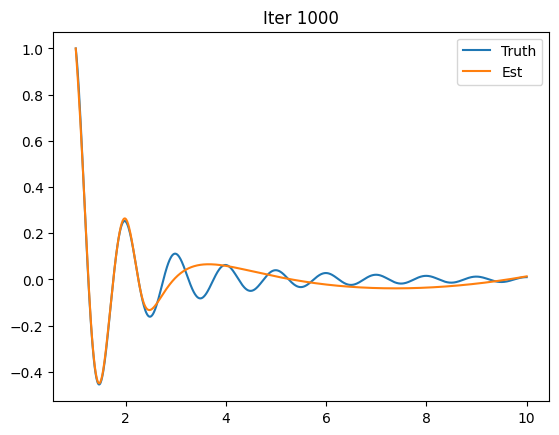

 22%|██▏       | 1100/5000 [06:45<16:47,  3.87it/s]  

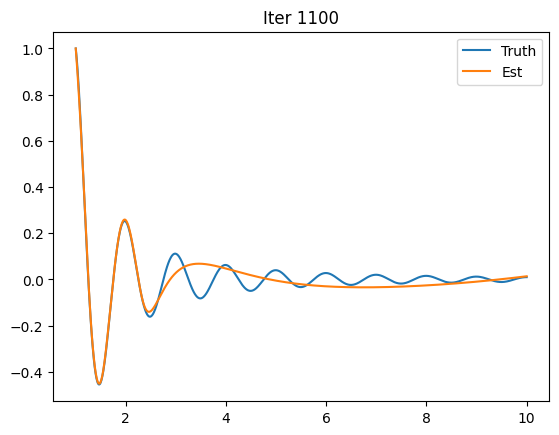

 24%|██▍       | 1200/5000 [07:18<16:15,  3.90it/s]  

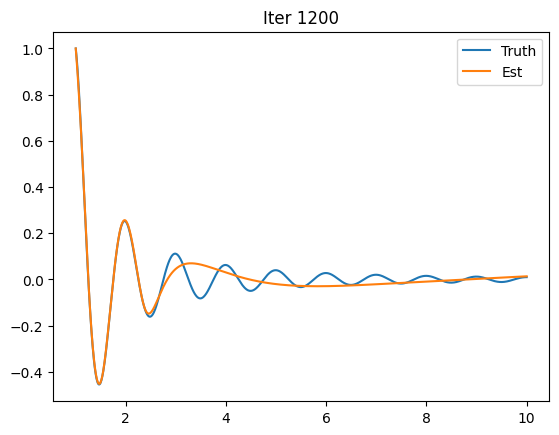

 26%|██▌       | 1300/5000 [07:52<15:55,  3.87it/s]  

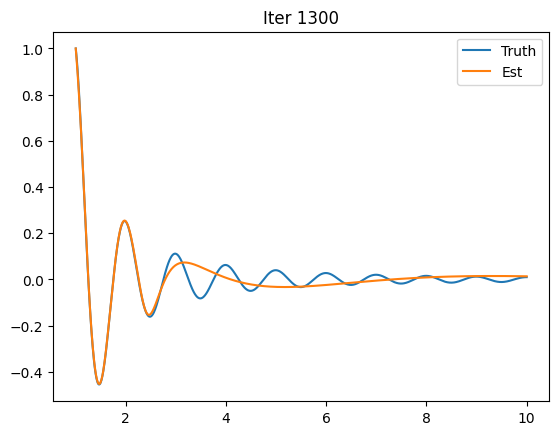

 28%|██▊       | 1400/5000 [08:25<15:33,  3.86it/s]  

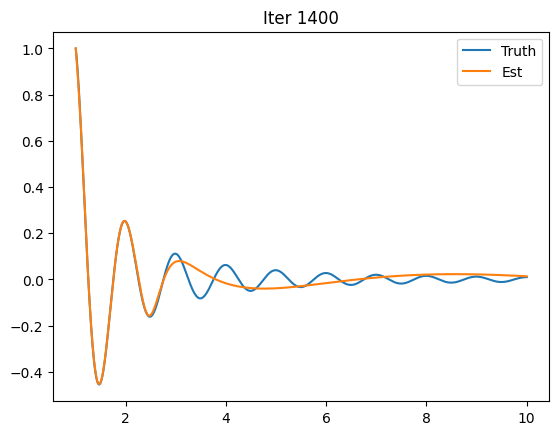

 30%|███       | 1500/5000 [08:58<15:09,  3.85it/s]  

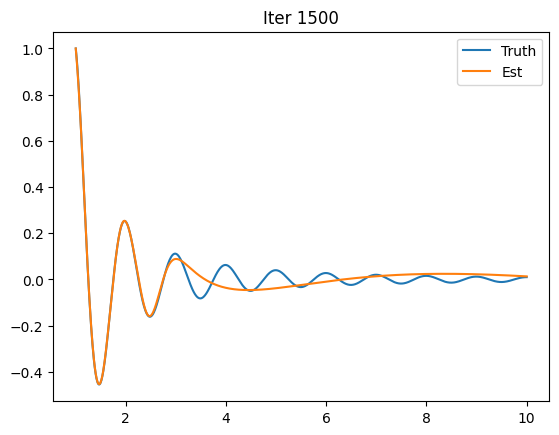

 32%|███▏      | 1600/5000 [09:32<14:47,  3.83it/s]  

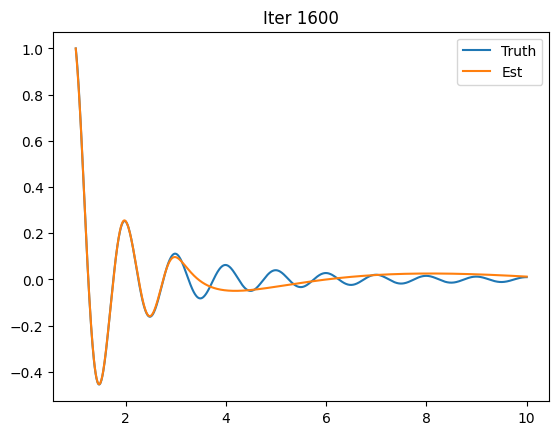

 34%|███▍      | 1700/5000 [10:06<20:29,  2.68it/s]  

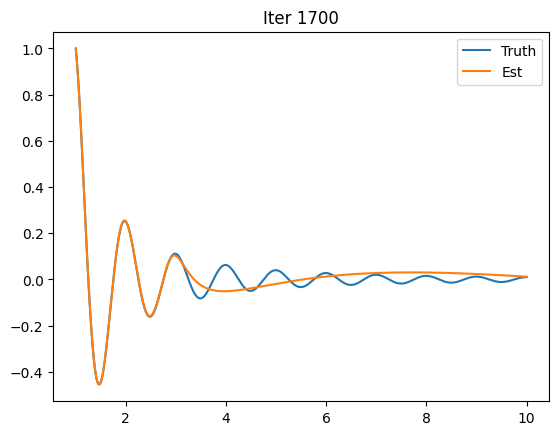

 36%|███▌      | 1800/5000 [10:51<20:03,  2.66it/s]  

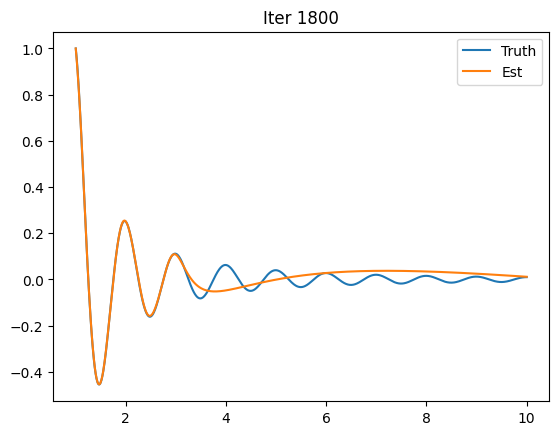

 38%|███▊      | 1900/5000 [11:37<19:51,  2.60it/s]  

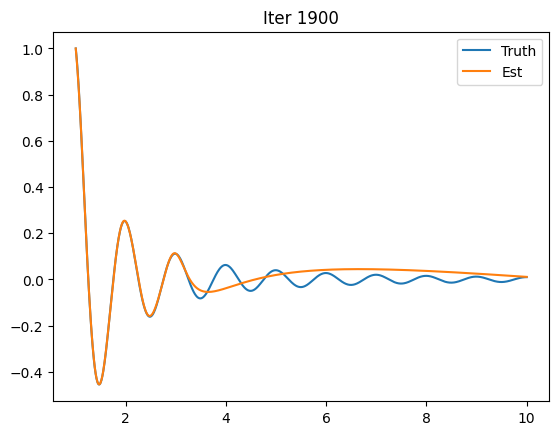

 40%|████      | 2000/5000 [12:23<24:03,  2.08it/s]  

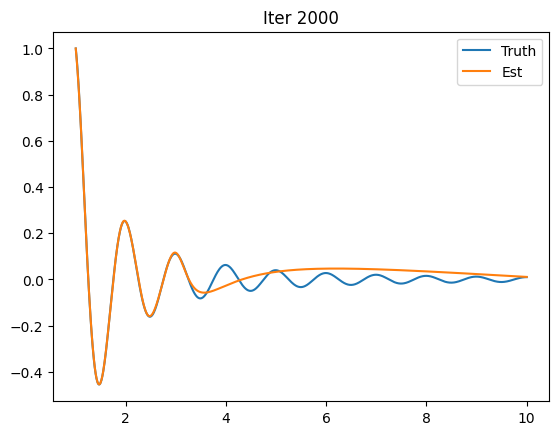

 42%|████▏     | 2100/5000 [13:21<23:52,  2.02it/s]  

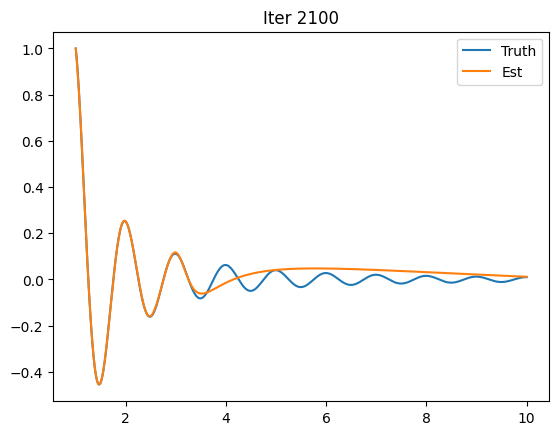

 44%|████▍     | 2200/5000 [14:18<23:16,  2.00it/s]  

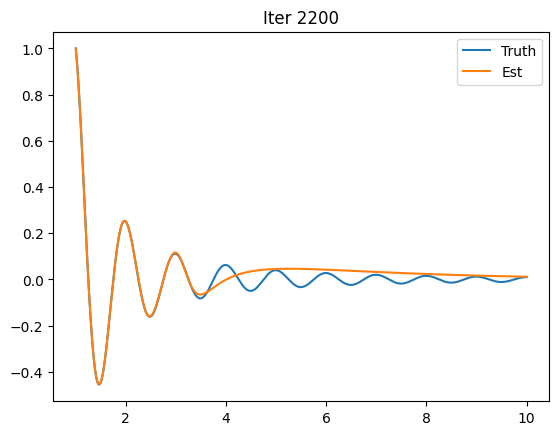

 46%|████▌     | 2300/5000 [15:15<22:22,  2.01it/s]  

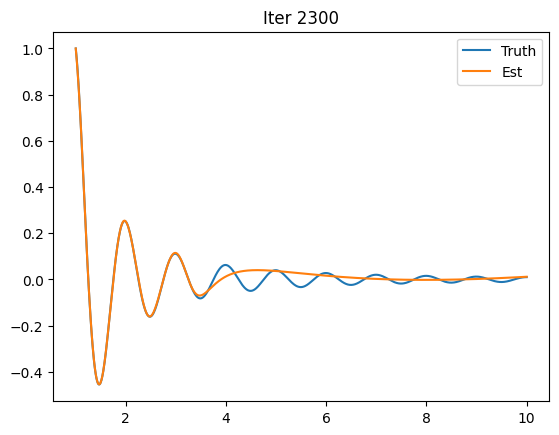

 48%|████▊     | 2400/5000 [16:17<26:55,  1.61it/s]  

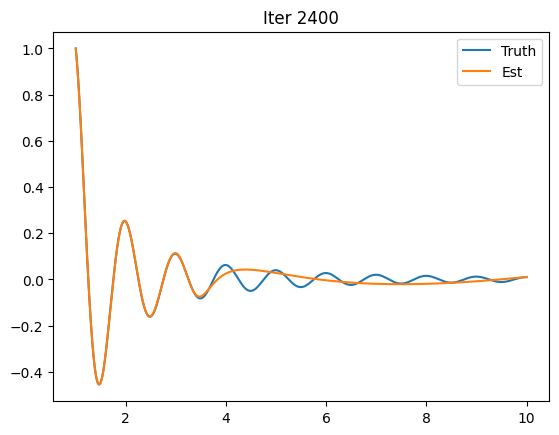

 50%|█████     | 2500/5000 [17:26<25:33,  1.63it/s]  

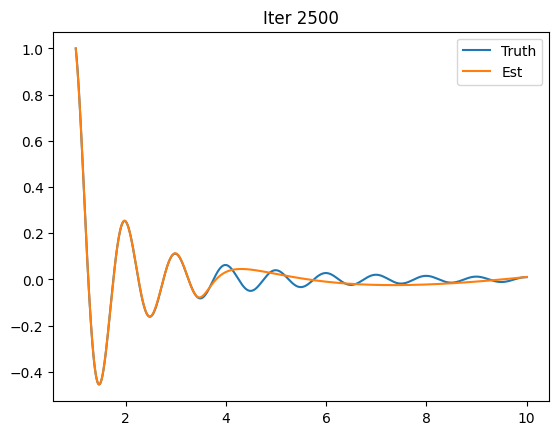

 52%|█████▏    | 2600/5000 [18:35<25:22,  1.58it/s]  

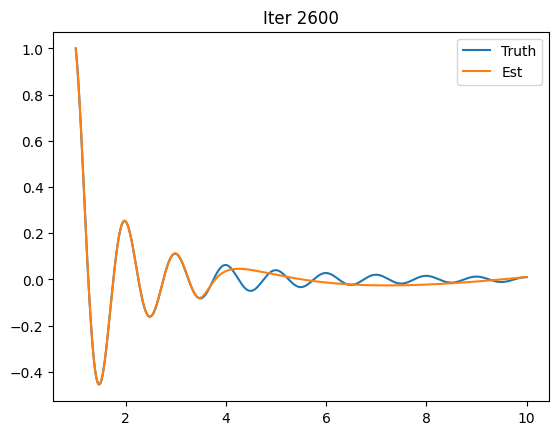

 54%|█████▍    | 2700/5000 [19:44<23:53,  1.60it/s]  

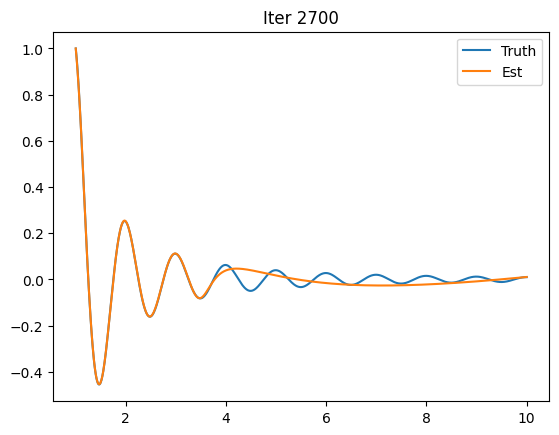

 56%|█████▌    | 2800/5000 [20:54<22:50,  1.61it/s]  

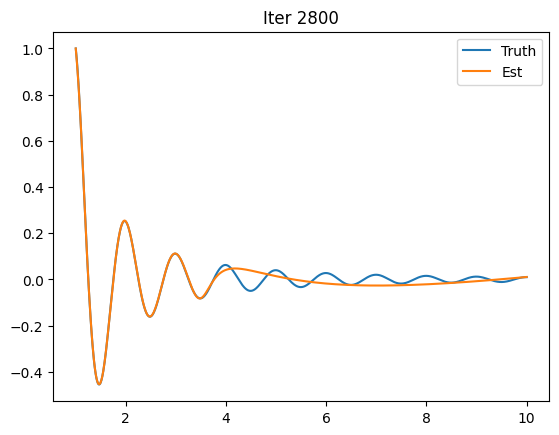

 58%|█████▊    | 2900/5000 [22:03<21:48,  1.60it/s]  

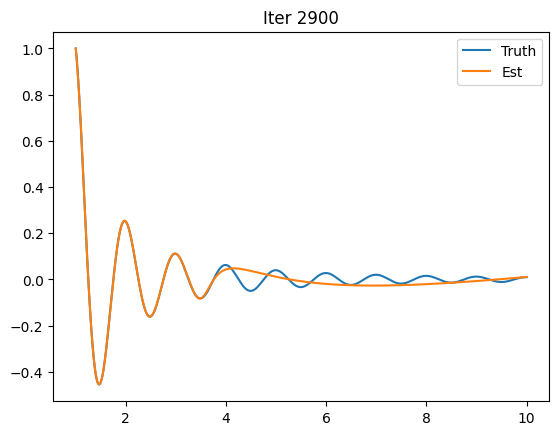

 60%|██████    | 3000/5000 [23:04<16:32,  2.01it/s]  

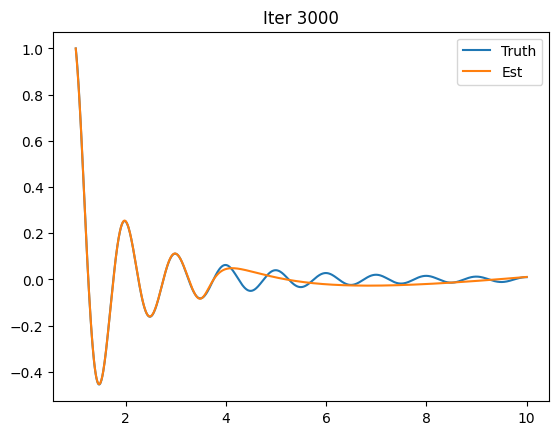

 62%|██████▏   | 3100/5000 [24:01<15:29,  2.04it/s]  

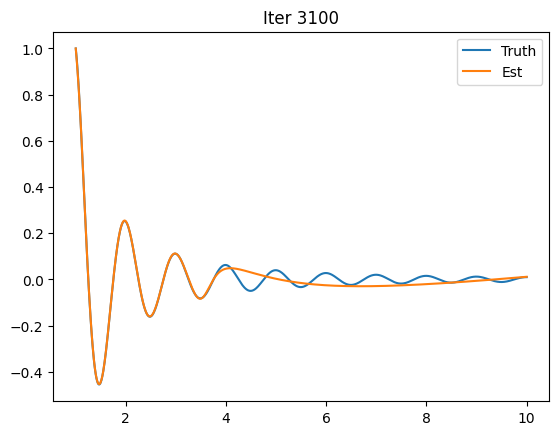

 64%|██████▍   | 3200/5000 [24:59<15:17,  1.96it/s]  

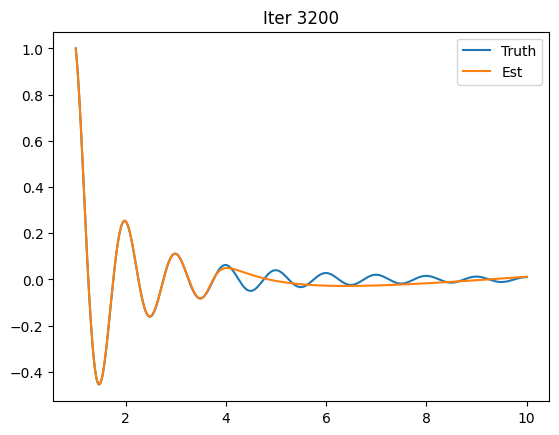

 66%|██████▌   | 3300/5000 [25:56<14:09,  2.00it/s]  

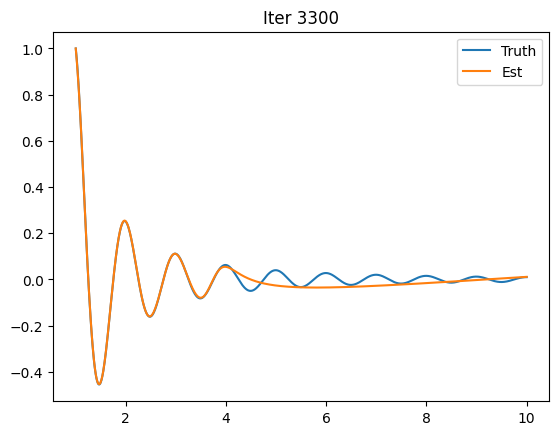

 68%|██████▊   | 3400/5000 [26:53<13:24,  1.99it/s]  

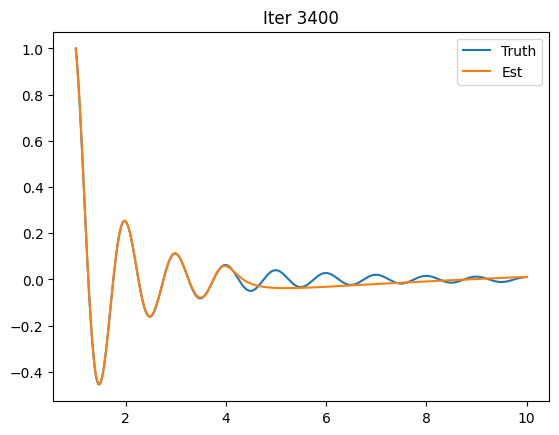

 70%|███████   | 3500/5000 [27:51<12:22,  2.02it/s]  

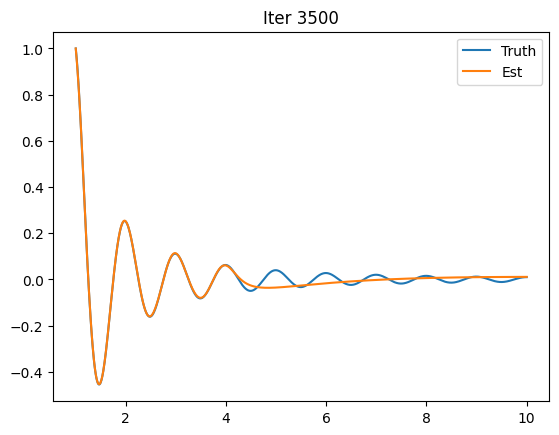

 72%|███████▏  | 3600/5000 [28:48<11:48,  1.98it/s]  

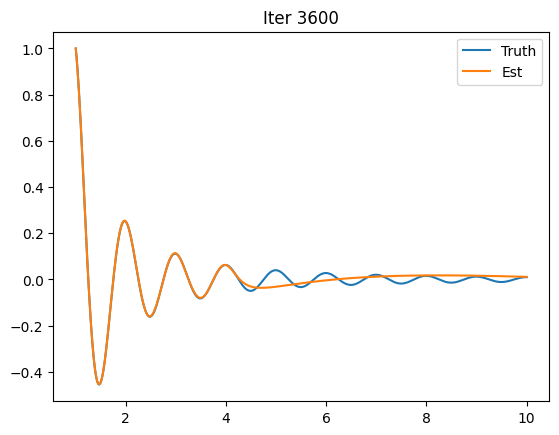

 74%|███████▍  | 3700/5000 [29:45<10:43,  2.02it/s]  

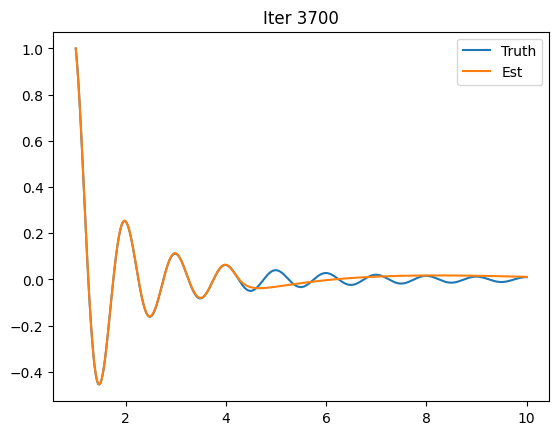

 76%|███████▌  | 3800/5000 [30:43<09:58,  2.01it/s]

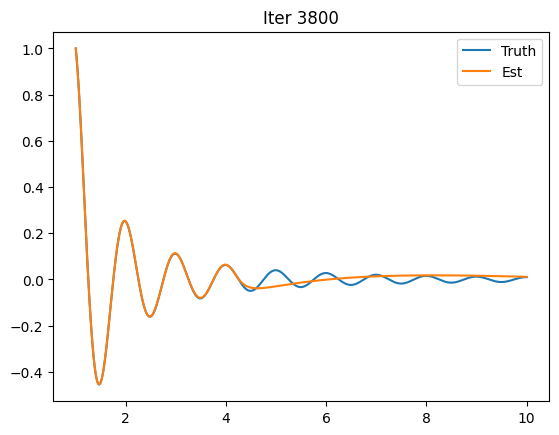

 78%|███████▊  | 3900/5000 [31:40<09:07,  2.01it/s]

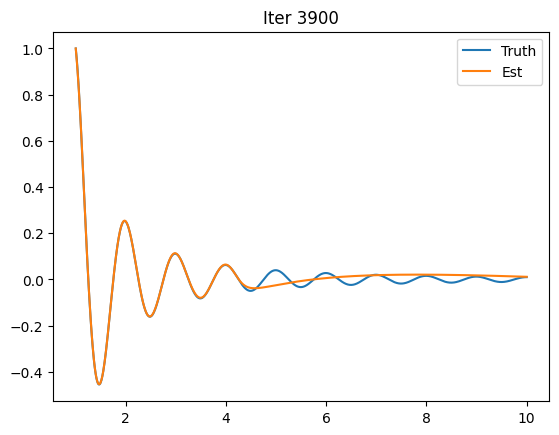

 80%|████████  | 4000/5000 [32:37<08:16,  2.01it/s]

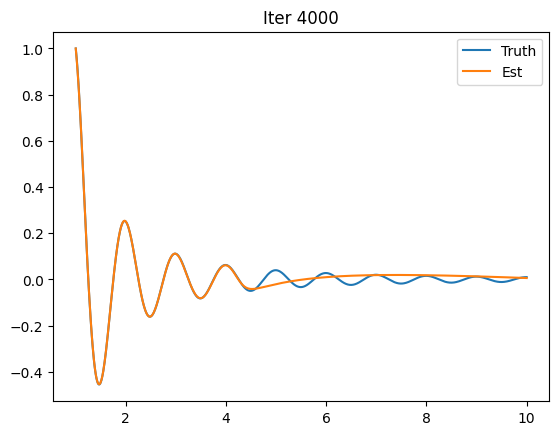

 82%|████████▏ | 4100/5000 [33:35<07:26,  2.02it/s]

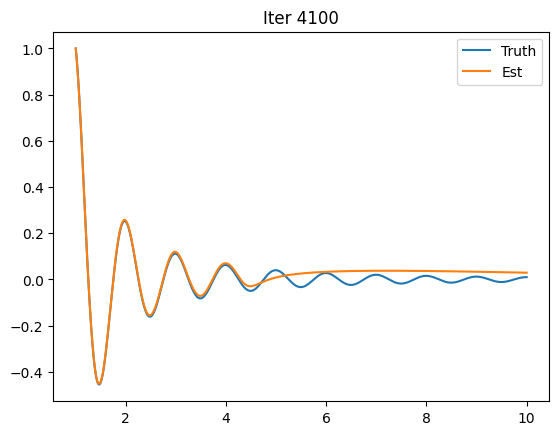

 84%|████████▍ | 4200/5000 [34:32<06:40,  2.00it/s]

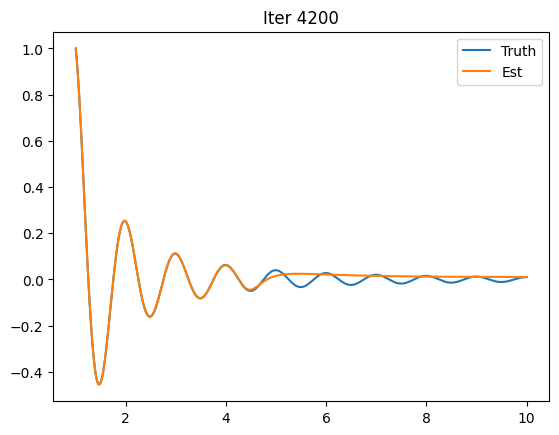

 86%|████████▌ | 4300/5000 [35:30<05:49,  2.00it/s]

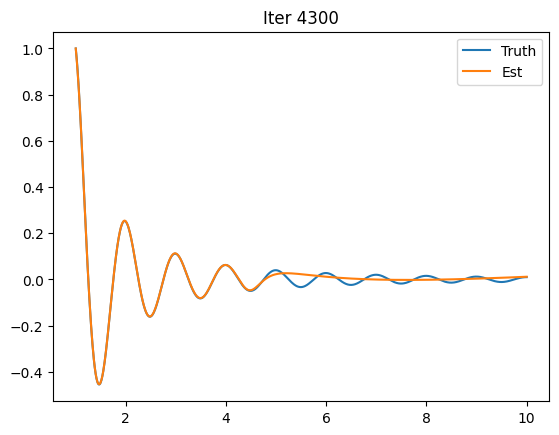

 88%|████████▊ | 4400/5000 [36:27<04:58,  2.01it/s]

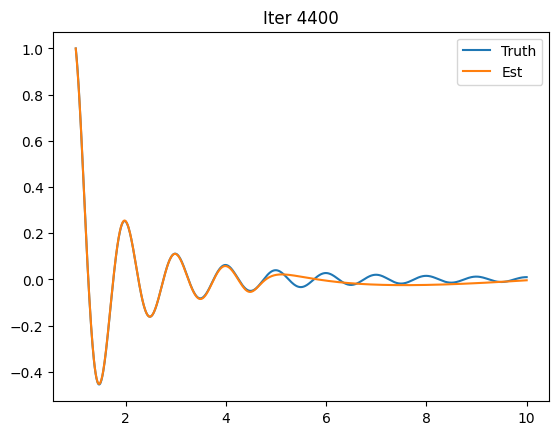

 90%|█████████ | 4500/5000 [37:25<04:11,  1.99it/s]

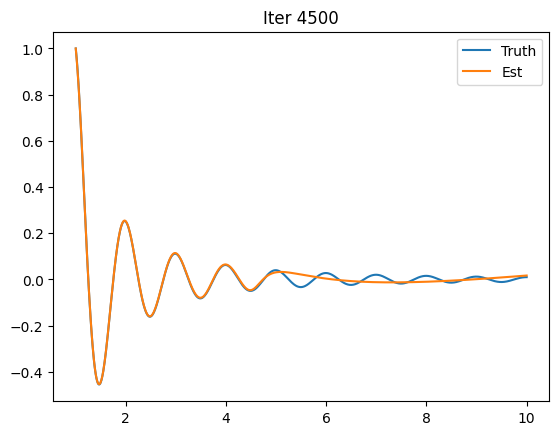

 92%|█████████▏| 4600/5000 [38:22<03:18,  2.01it/s]

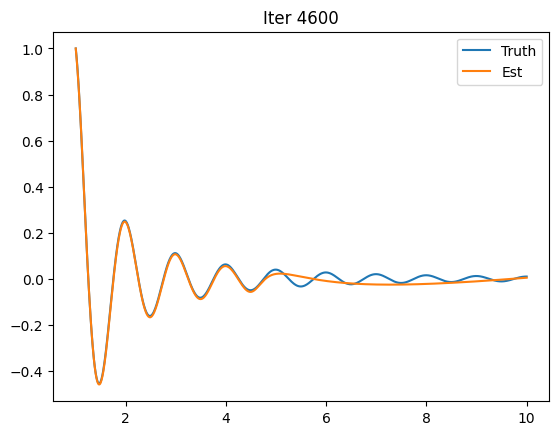

 94%|█████████▍| 4700/5000 [39:20<02:28,  2.02it/s]

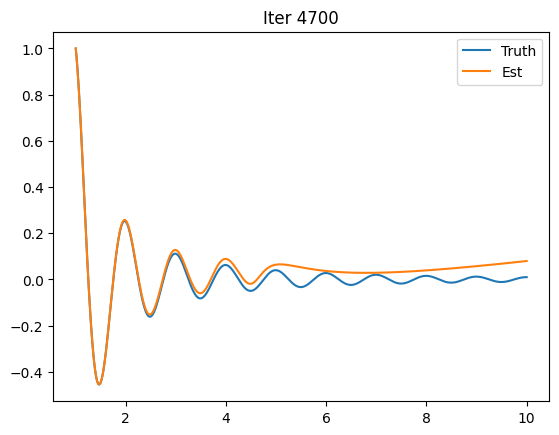

 96%|█████████▌| 4800/5000 [40:17<01:39,  2.02it/s]

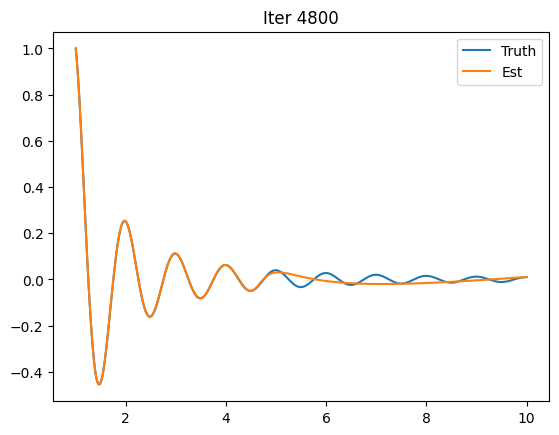

 98%|█████████▊| 4900/5000 [41:15<00:50,  1.99it/s]

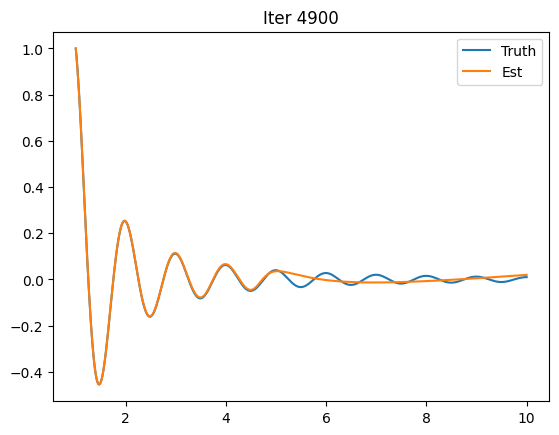

100%|██████████| 5000/5000 [42:12<00:00,  1.97it/s]


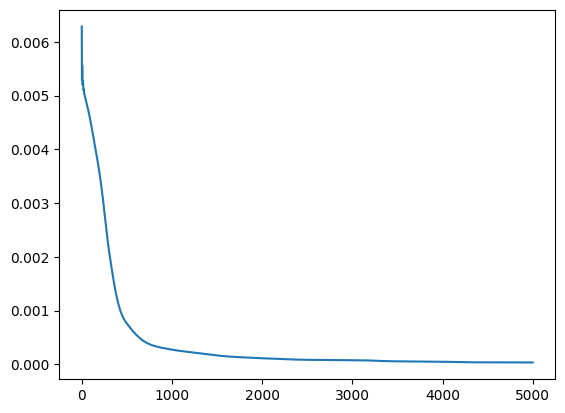

In [57]:
node_model = TimeDerivativeMLP()
solver = OdeintSolver(node_model, None, "rk4", None, False, None, None)

# train for specified epochs
losses = []
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

total_epochs = 5000
frames = []
for i in tqdm(range(total_epochs)):
    with tf.GradientTape() as tape:
        y_hat, *_ = solver(y_x_tf_batch[:, :1], x_tf_batch)
        loss = mse(y_x_tf_batch[:, -1], y_hat[:, -1, 0])
    grads = tape.gradient(loss, node_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, node_model.trainable_variables))
    losses.append(loss)

    if i % 100 == 0:
        y_hat, *_ = solver(y_x_t_0_tf, x_tf[None, :])
        plt.plot(x, y_x, label="Truth")
        plt.plot(x, y_hat[0, :, 0], label="Est")
        plt.title(f"Iter {i}")
        plt.legend()
        buf = io.BytesIO()
        plt.savefig(buf, format='png') # Save to in-memory buffer
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.show()
        plt.close()

plt.plot(losses)
frames[0].save(os.path.join("..", "docs", "1D_Fit_Animation.gif"), save_all=True, append_images=frames[1:], duration=1000, loop=0)